In [1]:
import sys, os, getpass

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [3]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings import CohereEmbeddings
from langchain_community.vectorstores import FAISS

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain_community.llms import Cohere
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.document_loaders import Docx2txtLoader

In [4]:
from RAG_utils import load_document, load_documents_from_folder

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [5]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import openai
openai_api_key=openai.api_key = os.environ['OPENAI_API_KEY']


In [6]:
import getpass
import os

os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [7]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [8]:
folder_path = "../data/Evaluation Sets/contract"  # Replace with your folder path
all_documents = load_documents_from_folder(folder_path)

In [9]:
all_documents

[Document(page_content="[R&G Draft 12.__.2021]\n\n\t\t \n\n\t\t \n\n\n\n\n\n\n\nSTOCK PURCHASE AGREEMENT\n\nBY AND AMONG\n\n[BUYER],\n\n[TARGET COMPANY],\n\nTHE SELLERS LISTED ON SCHEDULE I HERETO\n\nAND\n\nTHE SELLERS’ REPRESENTATIVE NAMED HEREIN\n\nDated as of [●]\n\n\n\n[This document is intended solely to facilitate discussions among the parties identified herein.  Neither this document nor such discussions are intended to create, nor will either or both be deemed to create, a legally binding or enforceable offer or agreement of any type or nature, unless and until a definitive written agreement is executed and delivered by each of the parties hereto.\n\n\n\nThis document shall be kept confidential pursuant to the terms of the Confidentiality Agreement entered into by the parties and, if applicable, its affiliates with respect to the subject matter hereof.]\n\n\n\n\n\nTABLE OF CONTENTS\n\n\tARTICLE I DEFINITIONS; CERTAIN RULES OF CONSTRUCTION\t2\n\n\t\tSection 1.01\tDefinitions\t2\

In [10]:
# document_path = "../data/Evaluation Sets/Raptor Contract.docx"
# documents=load_document(document_path)

In [11]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
# texts = text_splitter.split_documents(documents)


In [12]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=50)
split_texts = text_splitter.split_documents(all_documents)

In [13]:
len(split_texts)

466

In [14]:
retriever = FAISS.from_documents(split_texts, OpenAIEmbeddings()).as_retriever(
    search_kwargs={"k": 5}
)

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


## Multiple Query

In [15]:
query = "WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES? "
docs = retriever.get_relevant_documents(query)
pretty_print_docs(docs)

Document 1:

THE PARTIES IRREVOCABLY TO WAIVE THEIR RESPECTIVE RIGHTS TO TRIAL BY JURY IN ANY ACTION WHATSOEVER BETWEEN OR AMONG THEM RELATING TO THIS AGREEMENT, ANY ANCILLARY AGREEMENT OR ANY OF THE CONTEMPLATED TRANSACTIONS AND THAT SUCH ACTIONS WILL INSTEAD BE TRIED IN A COURT OF COMPETENT JURISDICTION BY A JUDGE SITTING WITHOUT A JURY.
----------------------------------------------------------------------------------------------------
Document 2:

Warrantholders

Preamble

Warrants

Recitals

Withholding Drop Date

2.09(b)



Certain Matters of Construction.

The parties have participated jointly in the negotiation and drafting of this Agreement.  In the event an ambiguity or question of intent or interpretation arises, this Agreement shall be construed as if drafted jointly by the parties and no presumption or burden of proof shall arise favoring or disfavoring any party by virtue of the authorship of any of the provisions of this Agreement.
---------------------------------------

In [16]:
# llm = OpenAI(temperature=0)
# compressor = LLMChainExtractor.from_llm(llm)
# compression_retriever = ContextualCompressionRetriever(
#     base_compressor=compressor, base_retriever=retriever
# )

In [17]:
# llm = Cohere(temperature=0)
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [18]:
compressed_docs = compression_retriever.get_relevant_documents(
    "How much is the escrow amount?"
)
pretty_print_docs(compressed_docs)

Document 1:

“Escrow Amount” means, $1,000,000

 “Facilities” means any buildings, plants, improvements or structures located on the Real Property.
----------------------------------------------------------------------------------------------------
Document 2:

“Equity Interest” means, with respect to any Person, (a) any capital stock, partnership or membership interest, unit of participation or other similar interest (however designated) in such Person and (b) any option, warrant, purchase right, conversion right, exchange right or other Contractual Obligation which would entitle any other Person to acquire any such interest in such Person or otherwise entitle any other Person to share in the equity, profits, earnings, losses or gains of such Person (including stock appreciation, phantom stock, profit participation or other similar rights).

“Escrow Amount” means, $1,000,000
----------------------------------------------------------------------------------------------------
Document 3

In [19]:
compressed_docs[0]

Document(page_content='“Escrow Amount” means, $1,000,000\n\n “Facilities” means any buildings, plants, improvements or structures located on the Real Property.', metadata={'source': '../data/Evaluation Sets/contract/Raptor Contract.docx', 'relevance_score': 0.95275027})

In [20]:
from langchain.chains import RetrievalQA

In [21]:
query=" WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES? "

In [22]:
# chain = RetrievalQA.from_chain_type(
#     llm=Cohere(temperature=0), retriever=compression_retriever
# )

In [23]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=compression_retriever)


In [24]:
query = "WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES?"
qa.run(query)

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


' The parties to the agreement are [BUYER], [TARGET COMPANY], the sellers listed on Schedule I, and the Sellers\' Representative. Their defined names are "Warrantholders" and "Withholding Drop Date."'

In [25]:
# chain({"query": query})

In [26]:
compressed_docs = compression_retriever.get_relevant_documents(
    "How much is the escrow amount?"
)
pretty_print_docs(compressed_docs)

Document 1:

“Escrow Amount” means, $1,000,000

 “Facilities” means any buildings, plants, improvements or structures located on the Real Property.
----------------------------------------------------------------------------------------------------
Document 2:

“Equity Interest” means, with respect to any Person, (a) any capital stock, partnership or membership interest, unit of participation or other similar interest (however designated) in such Person and (b) any option, warrant, purchase right, conversion right, exchange right or other Contractual Obligation which would entitle any other Person to acquire any such interest in such Person or otherwise entitle any other Person to share in the equity, profits, earnings, losses or gains of such Person (including stock appreciation, phantom stock, profit participation or other similar rights).

“Escrow Amount” means, $1,000,000
----------------------------------------------------------------------------------------------------
Document 3

In [28]:
# chain({"query": query})

In [29]:
# query="Can the Advisor charge for meal time?"
# chain({"query": query})

## RAGAS

In [30]:
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import OpenAI

In [31]:
llm = OpenAI(temperature=0)

In [52]:
#llm chain extractor
llm_compressor = LLMChainExtractor.from_llm(llm)
llm_compression_retriever = ContextualCompressionRetriever(
    base_compressor=llm_compressor, base_retriever=retriever
)

In [33]:
# llm = Cohere(temperature=0)
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [66]:
#Multiple Query
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=retriever, llm=llm
)

In [34]:
import json

json_file="../evaluation_data/raptor_context.json"

with open(json_file, "r") as f:
    data = json.load(f)

questions, ground_truth = [], []

for item in data:
    if "question" in item:  # Check if "question" key exists
        questions.append(item["question"])
    if "answer" in item:  # Check if "answer" key exists
        ground_truth.append(item["answer"])

print("Questions:")
for question in questions:
    print(question)

print("\nGround Truth:")
for answer in ground_truth:
    print(answer)

Questions:
Under what circumstances and to what extent are the sellers responsible for a breach of representations and warranties?
Are Change of Control Payments considered a Seller Transaction Expense? ?
How much is the escrow amount?
WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES?
WHAT IS THE TERMINATION NOTICE?
What are the payments to the Advisor under the Agreement?
Who owns the IP? 
What is the purpose of the escrow?
May the Escrow Amount serve as a recourse for the Buyer in case of breach of representations by the Company?

Ground Truth:
Except in the case of fraud, the sellers have no liability for breach of representations and warranties (See Section 10.01)
Yes. (See defining of Sellers Transaction Expenses).
The escrow amount is equal to $1,000,000.
CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")
According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot per

In [35]:
import json

json_file="../evaluation_data/raptor_context.json"  # Replace with your actual path

with open(json_file, "r") as f:
    data = json.load(f)

questions = []  # List to store extracted questions
for item in data:
    if "question" in item:
        questions.append(item["question"])

In [38]:
context = []
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = compression_retriever.get_relevant_documents(processed_question)

    # Extract and store only page_content
    context.extend([doc.page_content for doc in relevant_docs])

# Now the context list contains only page_content strings
print(context)

['legal and/or financial advisors, or (C)\xa0made in connection with the enforcement of any right or remedy relating to this Agreement or the Contemplated Transactions.  Each Seller agrees that it shall be responsible for any breach or violation of the provisions of this Section 6.05(a) by any of its Affiliates or its or its Affiliates’ Representatives.', 'The parties intend that each representation, warranty and covenant contained herein will have independent significance.  If any party has breached or violated, or if there is an inaccuracy in, any representation, warranty or covenant contained herein in any respect, the fact that there exists another representation, warranty or covenant relating to the same subject matter (regardless of the relative levels of specificity) which the party has not breached or violated, or in respect of which there is not an inaccuracy, will not detract from or mitigate the fact that the party has breached or violated, or there is an inaccuracy in, the 

In [40]:
answers = []  # Create an empty list to store answers for each question
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question and context (if needed)
    answer = qa.run(processed_question)  # Include context if necessary

    # Append answer to the answers list
    answers.append(answer)

answers  # This will print a list of answers for each question

[" The sellers are responsible for any breach or violation of the provisions in connection with the enforcement of any right or remedy relating to the Agreement or the Contemplated Transactions. However, if there is an inaccuracy or breach of one representation, warranty, or covenant, it does not detract from or mitigate the fact that there may be a breach or inaccuracy in another representation, warranty, or covenant. The Sellers' Representative may also rely on the advice of legal and/or financial advisors, and will not be held liable for any actions taken in good faith based on such advice.",
 ' Yes, change of control payments are considered a seller transaction expense. This is stated in the definition of "Change of Control Payment" in the given context.',
 ' The escrow amount is $1,000,000.',
 ' The parties to the agreement are not explicitly named in the provided context. Additional information would be needed to accurately identify the parties.',
 " I don't know. \n",
 ' The pay

In [41]:
print(type(answers))

<class 'list'>


In [43]:
context_lists = []

for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = compression_retriever.get_relevant_documents(processed_question)

    # Create a new list for this question's context
    context_for_question = []

    # Extract and store only page_content (assuming Document has a page_content attribute)
    context_for_question.extend([doc.page_content for doc in relevant_docs])

    # Append the question's context list with only page_content to the main list
    context_lists.append(context_for_question)

# Now context_lists contains lists of page_content strings for each question

context_lists

[['legal and/or financial advisors, or (C)\xa0made in connection with the enforcement of any right or remedy relating to this Agreement or the Contemplated Transactions.  Each Seller agrees that it shall be responsible for any breach or violation of the provisions of this Section 6.05(a) by any of its Affiliates or its or its Affiliates’ Representatives.',
  'The parties intend that each representation, warranty and covenant contained herein will have independent significance.  If any party has breached or violated, or if there is an inaccuracy in, any representation, warranty or covenant contained herein in any respect, the fact that there exists another representation, warranty or covenant relating to the same subject matter (regardless of the relative levels of specificity) which the party has not breached or violated, or in respect of which there is not an inaccuracy, will not detract from or mitigate the fact that the party has breached or violated, or there is an inaccuracy in, t

In [44]:
ground_truths_lists = [[item] for item in ground_truth]

# Print the modified list of lists
print("Ground Truths (List of Lists):")
for sublist in ground_truths_lists:
    print(sublist)

Ground Truths (List of Lists):
['Except in the case of fraud, the sellers have no liability for breach of representations and warranties (See Section 10.01)']
['Yes. (See defining of Sellers Transaction Expenses).']
['The escrow amount is equal to $1,000,000.']
['CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")']
['According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.']
['According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1,500, 2. Workspace expense of $100 per month, 3. Other reasonable and actual expenses if approved by the company in writing and in advance.']
['According to section 4 of the Undertaking (Appendix A), Any Work Product, upon creation, shall be fully and exclusively owned by the Company.']
['To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase

In [45]:
from datasets import Dataset
data = {
    "question": questions, # list 
    "answer": answers, # list
    "contexts": context_lists, # list list
    "ground_truths": ground_truths_lists # list Lists
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        
    ],
)

df = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 36/36 [00:51<00:00,  1.42s/it]


In [47]:
df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent ar...,The sellers are responsible for any breach or...,"[legal and/or financial advisors, or (C) made ...","[Except in the case of fraud, the sellers have...","Except in the case of fraud, the sellers have ...",0.000000,1.000000,1.0,0.845424
1,Are Change of Control Payments considered a Se...,"Yes, change of control payments are considere...",[(ii) the fees and expenses of the Company’s l...,[Yes. (See defining of Sellers Transaction Exp...,Yes. (See defining of Sellers Transaction Expe...,1.000000,1.000000,0.0,0.984466
2,How much is the escrow amount?,"The escrow amount is $1,000,000.","[“Escrow Amount” means, $1,000,000\n\n “Facili...","[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",1.000000,1.000000,1.0,0.982518
3,WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ...,The parties to the agreement are not explicit...,"[WHEREAS, the parties further desire that all ...","[CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK R...","CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK RO...",1.000000,1.000000,NaN,0.000000
4,WHAT IS THE TERMINATION NOTICE?,I don't know. \n,[payoff and lien release letters in form and s...,[According to section 4: 14 days for convenien...,According to section 4: 14 days for convenienc...,0.000000,0.000000,NaN,0.773834
5,What are the payments to the Advisor under the...,The payments to the advisor under the agreeme...,[Compensation:\n\nAs full and sole considerati...,[According to section 6: 1. Fees of $9 per hou...,According to section 6: 1. Fees of $9 per hour...,1.000000,0.666667,1.0,0.990388
6,Who owns the IP?,The Company owns the IP.,"[IP: Any Work Product, upon creation, shall be...",[According to section 4 of the Undertaking (Ap...,According to section 4 of the Undertaking (App...,1.000000,1.000000,1.0,0.978999
7,What is the purpose of the escrow?,The purpose of the escrow is to hold and disb...,"[At Closing, Buyer will deposit the Escrow Amo...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,0.833333,1.000000,1.0,1.000000
8,May the Escrow Amount serve as a recourse for ...,"Yes, the escrow amount can serve as a recours...",[Recovery from the Escrow Amount shall constit...,[No],No,0.000000,0.000000,1.0,0.959109


In [48]:
# Assuming 'df' is your DataFrame
numeric_columns = df.select_dtypes(include=['number'])
average_values = numeric_columns.mean().round(2).rename("Average")
print("Average:")
print(average_values)

Average:
context_precision    0.65
context_recall       0.74
faithfulness         0.86
answer_relevancy     0.83
Name: Average, dtype: float64


## LLM chain Extractor for reranking

In [53]:
import json

json_file="../evaluation_data/raptor_context.json"  # Replace with your actual path

with open(json_file, "r") as f:
    data = json.load(f)

questions = []  # List to store extracted questions
for item in data:
    if "question" in item:
        questions.append(item["question"])

In [ ]:
context = []
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = llm_compression_retriever.get_relevant_documents(processed_question)

    # Extract and store only page_content
    context.extend([doc.page_content for doc in relevant_docs])

# Now the context list contains only page_content strings
print(context)

In [55]:
answers = []  # Create an empty list to store answers for each question
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question and context (if needed)
    answer = qa.run(processed_question)  # Include context if necessary

    # Append answer to the answers list
    answers.append(answer)

answers  # This will print a list of answers for each question

[" The sellers are responsible for any breach or violation of the provisions of this Section 6.05(a) by any of its Affiliates or its or its Affiliates’ Representatives. They are also responsible for any actions or omissions of the Sellers' Representative, except in cases of gross negligence, bad faith, or willful misconduct. The Sellers' Representative may also seek advice from professionals and will not be liable for any actions taken in good faith based on that advice. Each seller will be responsible individually for any breach of representations and warranties.",
 ' Yes, change of control payments are considered a seller transaction expense. This can be inferred from the context provided, specifically in the definition of "Change of Control Payment" which mentions that it includes any payment or compensation payable to any present or former employee of any Acquired Company. This falls under the category of seller transaction expenses as stated in the agreement.',
 ' $1,000,000',
 " 

In [56]:
print(type(answers))

<class 'list'>


In [ ]:
context_lists = []

for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = llm_compression_retriever.get_relevant_documents(processed_question)

    # Create a new list for this question's context
    context_for_question = []

    # Extract and store only page_content (assuming Document has a page_content attribute)
    context_for_question.extend([doc.page_content for doc in relevant_docs])

    # Append the question's context list with only page_content to the main list
    context_lists.append(context_for_question)

# Now context_lists contains lists of page_content strings for each question

context_lists

In [58]:
ground_truths_lists = [[item] for item in ground_truth]

# Print the modified list of lists
print("Ground Truths (List of Lists):")
for sublist in ground_truths_lists:
    print(sublist)

Ground Truths (List of Lists):
['Except in the case of fraud, the sellers have no liability for breach of representations and warranties (See Section 10.01)']
['Yes. (See defining of Sellers Transaction Expenses).']
['The escrow amount is equal to $1,000,000.']
['CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")']
['According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.']
['According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1,500, 2. Workspace expense of $100 per month, 3. Other reasonable and actual expenses if approved by the company in writing and in advance.']
['According to section 4 of the Undertaking (Appendix A), Any Work Product, upon creation, shall be fully and exclusively owned by the Company.']
['To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase

In [59]:
from datasets import Dataset
data = {
    "question": questions, # list 
    "answer": answers, # list
    "contexts": context_lists, # list list
    "ground_truths": ground_truths_lists # list Lists
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [60]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        
    ],
)

df_llm_extractor = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 36/36 [00:19<00:00,  1.82it/s]


In [61]:
df_llm_extractor

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent ar...,The sellers are responsible for any breach or...,[- The Sellers’ Representative shall not be he...,"[Except in the case of fraud, the sellers have...","Except in the case of fraud, the sellers have ...",0.833333,1.0,0.75,0.846652
1,Are Change of Control Payments considered a Se...,"Yes, change of control payments are considere...","[- ""Seller Transaction Expenses"" means all cos...",[Yes. (See defining of Sellers Transaction Exp...,Yes. (See defining of Sellers Transaction Expe...,1.000000,1.0,NaN,0.984466
2,How much is the escrow amount?,"$1,000,000","[Escrow., ""Escrow Amount"" means, $1,000,000, “...","[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",0.583333,1.0,1.00,0.910100
3,WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ...,I don't know.,[The parties have participated jointly in the ...,"[CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK R...","CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK RO...",0.416667,0.5,NaN,0.000000
4,WHAT IS THE TERMINATION NOTICE?,It is not specified in the given context.,"[with notice or lapse of time or both, would c...",[According to section 4: 14 days for convenien...,According to section 4: 14 days for convenienc...,0.000000,0.0,NaN,0.000000
5,What are the payments to the Advisor under the...,The payments to the advisor under the agreeme...,[payments to Advisor hereunder shall be reduce...,[According to section 6: 1. Fees of $9 per hou...,According to section 6: 1. Fees of $9 per hour...,0.583333,1.0,1.00,0.990385
6,Who owns the IP?,\n\nThe Company owns the intellectual property.,"[Any Work Product, upon creation, shall be ful...",[According to section 4 of the Undertaking (Ap...,According to section 4 of the Undertaking (App...,1.000000,1.0,1.00,0.954653
7,What is the purpose of the escrow?,The purpose of the escrow is to hold and disb...,"[Escrow., - the Escrow Agreement\n- any disbur...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,0.583333,1.0,1.00,1.000000
8,May the Escrow Amount serve as a recourse for ...,"Yes, the escrow amount can serve as the buyer...",[Recovery from the Escrow Amount shall constit...,[No],No,0.250000,0.0,1.00,0.915710


In [62]:
# Assuming 'df' is your DataFrame
numeric_columns = df_llm_extractor.select_dtypes(include=['number'])
average_values = numeric_columns.mean().round(2).rename("Average")
print("Average:")
print(average_values)

Average:
context_precision    0.58
context_recall       0.72
faithfulness         0.96
answer_relevancy     0.73
Name: Average, dtype: float64


## Multiple Query

In [67]:
import json

json_file="../evaluation_data/raptor_context.json"  # Replace with your actual path

with open(json_file, "r") as f:
    data = json.load(f)

questions = []  # List to store extracted questions
for item in data:
    if "question" in item:
        questions.append(item["question"])

In [68]:
context = []
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = retriever_from_llm.get_relevant_documents(processed_question)

    # Extract and store only page_content
    context.extend([doc.page_content for doc in relevant_docs])

# Now the context list contains only page_content strings
print(context)

['Provisions Concerning the Sellers’ Representative.', 'Liability.  The Sellers’ Representative shall not be held liable by any of the Sellers for actions or omissions in exercising or failing to exercise all or any of the power and authority of the Sellers’ Representative pursuant to this Agreement, except in the case of the Sellers’ Representative’s gross negligence, bad faith or willful misconduct.  The Sellers’ Representative shall be entitled to rely on the advice of counsel, public accountants or other independent experts that it reasonably determines to be experienced in the matter at issue, and will not be liable to any Seller for any action taken or omitted to be taken in good faith based on such advice.  Each Seller will severally (and', 'The parties intend that each representation, warranty and covenant contained herein will have independent significance.  If any party has breached or violated, or if there is an inaccuracy in, any representation, warranty or covenant contain

In [69]:
answers = []  # Create an empty list to store answers for each question
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question and context (if needed)
    answer = qa.run(processed_question)  # Include context if necessary

    # Append answer to the answers list
    answers.append(answer)

answers  # This will print a list of answers for each question

[" The sellers are responsible for any breach or violation of the provisions of the Agreement or Contemplated Transactions by their affiliates or representatives. They are also responsible for any breaches or violations of representations, warranties, or covenants contained in the Agreement, regardless of whether there are other representations, warranties, or covenants relating to the same subject matter that have not been breached. However, the Sellers' Representative will not be held liable for actions or omissions unless there is gross negligence, bad faith, or willful misconduct. The Sellers' Representative is also entitled to rely on the advice of experts and will not be held liable for any action taken or omitted in good faith based on such advice.",
 ' Yes. Change of control payments are considered a seller transaction expense.',
 ' The escrow amount is $1,000,000.',
 ' The parties to the agreement are not explicitly stated in the context provided, so it is not possible to dete

In [70]:
print(type(answers))

<class 'list'>


In [71]:
context_lists = []

for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = retriever_from_llm.get_relevant_documents(processed_question)

    # Create a new list for this question's context
    context_for_question = []

    # Extract and store only page_content (assuming Document has a page_content attribute)
    context_for_question.extend([doc.page_content for doc in relevant_docs])

    # Append the question's context list with only page_content to the main list
    context_lists.append(context_for_question)

# Now context_lists contains lists of page_content strings for each question

context_lists

[['Provisions Concerning the Sellers’ Representative.',
  'Liability.  The Sellers’ Representative shall not be held liable by any of the Sellers for actions or omissions in exercising or failing to exercise all or any of the power and authority of the Sellers’ Representative pursuant to this Agreement, except in the case of the Sellers’ Representative’s gross negligence, bad faith or willful misconduct.  The Sellers’ Representative shall be entitled to rely on the advice of counsel, public accountants or other independent experts that it reasonably determines to be experienced in the matter at issue, and will not be liable to any Seller for any action taken or omitted to be taken in good faith based on such advice.  Each Seller will severally (and',
  'legal and/or financial advisors, or (C)\xa0made in connection with the enforcement of any right or remedy relating to this Agreement or the Contemplated Transactions.  Each Seller agrees that it shall be responsible for any breach or vi

In [72]:
ground_truths_lists = [[item] for item in ground_truth]

# Print the modified list of lists
print("Ground Truths (List of Lists):")
for sublist in ground_truths_lists:
    print(sublist)

Ground Truths (List of Lists):
['Except in the case of fraud, the sellers have no liability for breach of representations and warranties (See Section 10.01)']
['Yes. (See defining of Sellers Transaction Expenses).']
['The escrow amount is equal to $1,000,000.']
['CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")']
['According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.']
['According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1,500, 2. Workspace expense of $100 per month, 3. Other reasonable and actual expenses if approved by the company in writing and in advance.']
['According to section 4 of the Undertaking (Appendix A), Any Work Product, upon creation, shall be fully and exclusively owned by the Company.']
['To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase

In [73]:
from datasets import Dataset
data = {
    "question": questions, # list 
    "answer": answers, # list
    "contexts": context_lists, # list list
    "ground_truths": ground_truths_lists # list Lists
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [74]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        
    ],
)

df_multiple_query = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Evaluating: 100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


In [75]:
df_multiple_query

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent ar...,The sellers are responsible for any breach or...,[Provisions Concerning the Sellers’ Representa...,"[Except in the case of fraud, the sellers have...","Except in the case of fraud, the sellers have ...",0.000000,1.0,0.75,0.905590
1,Are Change of Control Payments considered a Se...,Yes. Change of control payments are considere...,[“Seller Transaction Expenses” means all costs...,[Yes. (See defining of Sellers Transaction Exp...,Yes. (See defining of Sellers Transaction Expe...,0.770833,1.0,NaN,0.984466
2,How much is the escrow amount?,"The escrow amount is $1,000,000.","[Escrow., “Equity Interest” means, with respec...","[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",0.583333,1.0,1.00,0.962389
3,WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ...,The parties to the agreement are not explicit...,[Warrantholders\n\nPreamble\n\nWarrants\n\nRec...,"[CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK R...","CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK RO...",0.250000,1.0,NaN,0.000000
4,WHAT IS THE TERMINATION NOTICE?,I don't know.,"[pension, pay slips, working during work day, ...",[According to section 4: 14 days for convenien...,According to section 4: 14 days for convenienc...,0.642857,0.0,NaN,0.000000
5,What are the payments to the Advisor under the...,The payments to the advisor under the agreeme...,[Compensation:\n\nAs full and sole considerati...,[According to section 6: 1. Fees of $9 per hou...,According to section 6: 1. Fees of $9 per hour...,0.755556,1.0,1.00,0.990385
6,Who owns the IP?,The Company owns the intellectual property.,"[IP: Any Work Product, upon creation, shall be...",[According to section 4 of the Undertaking (Ap...,According to section 4 of the Undertaking (App...,1.000000,1.0,1.00,0.954653
7,What is the purpose of the escrow?,The purpose of the escrow is to hold and rele...,"[Escrow., At Closing, Buyer will deposit the E...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,0.710000,1.0,1.00,1.000000
8,May the Escrow Amount serve as a recourse for ...,"Yes, according to the context provided, the E...",[Recovery from the Escrow Amount shall constit...,[No],No,0.142857,0.0,1.00,0.904808


In [77]:
# Assuming 'df' is your DataFrame
numeric_columns = df_multiple_query.select_dtypes(include=['number'])
average_values = numeric_columns.mean().round(2).rename("Average")
print("Average:")
print(average_values)

Average:
context_precision    0.54
context_recall       0.78
faithfulness         0.96
answer_relevancy     0.74
Name: Average, dtype: float64


# Comparison of the Cohere reranker, LLM chain extractor for reranking and Multiple Query approches

In [78]:
import pandas as pd

# Calculate the mean of the specified metrics for each dataframe
Cohere_mean = df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
llmextaractor_mean = df_llm_extractor[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
multiple_query = df_multiple_query[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()

# Create dataframes for each mean value
cohere_mean_df = pd.DataFrame(Cohere_mean, columns=['Cohere_mean'])
llmExtractor_mean_df = pd.DataFrame(llmextaractor_mean, columns=['llmExtaractor_mean'])
multipleQuery_df = pd.DataFrame(multiple_query, columns=['multipleQuery_Mean'])

# Concatenate the dataframes horizontally
mean_comparison_df = pd.concat([cohere_mean_df, llmExtractor_mean_df, multipleQuery_df], axis=1)

# Print the mean values for all dataframes in a single table horizontally
print(mean_comparison_df)


                   Cohere_mean  llmExtaractor_mean  multipleQuery_Mean
context_precision     0.648148            0.583333            0.539493
context_recall        0.740741            0.722222            0.777778
faithfulness          0.857143            0.958333            0.958333
answer_relevancy      0.834971            0.733552            0.744699


                   Cohere_mean  llmExtaractor_mean  multipleQuery_Mean
context_precision     0.648148            0.583333            0.539493
context_recall        0.740741            0.722222            0.777778
faithfulness          0.857143            0.958333            0.958333
answer_relevancy      0.834971            0.733552            0.744699


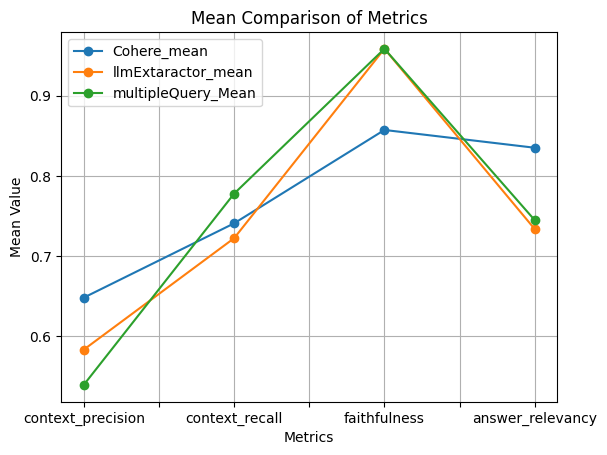

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the mean of the specified metrics for each dataframe
Cohere_mean = df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
llmextaractor_mean = df_llm_extractor[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
multiple_query = df_multiple_query[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()

# Create dataframes for each mean value
cohere_mean_df = pd.DataFrame(Cohere_mean, columns=['Cohere_mean'])
llmExtractor_mean_df = pd.DataFrame(llmextaractor_mean, columns=['llmExtaractor_mean'])
multipleQuery_df = pd.DataFrame(multiple_query, columns=['multipleQuery_Mean'])

# Concatenate the dataframes horizontally
mean_comparison_df = pd.concat([cohere_mean_df, llmExtractor_mean_df, multipleQuery_df], axis=1)

# Print the mean values for all dataframes in a single table horizontally
print(mean_comparison_df)

# Plotting the mean values as a line graph
mean_comparison_df.plot(kind='line', marker='o')
plt.title('Mean Comparison of Metrics')
plt.xlabel('Metrics')
plt.ylabel('Mean Value')
plt.grid(True)
plt.legend(['Cohere_mean', 'llmExtaractor_mean', 'multipleQuery_Mean'])
plt.show()
